In [2]:
from collections import OrderedDict
from time import time
import re
import json
import math
from natsort import natsorted
from glob import glob
from pathlib import Path
import os

# import pydot
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_pydot import read_dot

from matplotlib import collections  as mc
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from IPython.display import clear_output

nodePattern = re.compile('^(\d+) ')
edgePattern = re.compile('^(\d+) -- (\d+)')
attrsPattern = re.compile('\[(.+)\]')

def isNode(line):
    return '--' not in line


def processAttrs(line):
    attrs = attrsPattern.findall(line)
    if len(attrs) > 0:
        attrs = attrs[0].split(',')
    attrs = [a.split('=') for a in attrs]
    attrs = [[a[0].strip(), a[1].replace('"','').strip()] for a in attrs]
    for a in attrs:
        try:
            a[1] = int(a[1])
        except ValueError:
            try:
                a[1] = float(a[1])
            except:
                pass
    return attrs


def processEdge(line):
    finding = edgePattern.findall(line)[0]
    source, target = finding[:2]
    source, target = int(source), int(target)
    attrs = processAttrs(line)
    return dict(attrs, source=source, target=target)


def processNode(line):
    nodeId = int(line.split(' ')[0])
    nodeAttrs = processAttrs(line)
    return dict(nodeAttrs, id=nodeId)


def draw(g, pos, edges=True, labels=True, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
#     plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    plt.show()

#     plt.figure(figsize=figsize)
#     nx.draw(
#         g, 
#         pos=pos,
#         node_size=10,
#         width=0.5,
#     )




def subtree_sizes(tree, root):
    tree = nx.bfs_tree(g, source=root)
    s = [len(nx.bfs_tree(tree, i).nodes) for i in tree.neighbors(root)]
    total = sum(s)
    return np.array(s)


def fan(nodes, origin=[0,0], radius=1, phaseCenter=0, phaseRange=np.pi, ratio=[1,1]):
    pos = {}
    phases = {}
    ranges = {}
    n = len(nodes)
    cos, sin = np.cos, np.sin
    
    ratioTotal = sum(ratio)
    ratio = [r/ratioTotal for r in ratio]
    
    
    nr = sorted(zip(nodes, ratio), key=lambda x:x[1])
    nr2 = []
    for i in range(len(nr)-1, -1, -1):
        if i%2 == 0:
            nr2.append(nr[i])
        else:
            nr2.insert(0, nr[i])
    nodes, ratio = zip(*nr2)
    
    
    ratioCumSum = [sum(ratio[:i]) for i in range(len(ratio)+1)]
    for i in range(n):
        angle_offset = (ratioCumSum[i]+ratioCumSum[i+1])/2 * phaseRange
        angle_i = phaseCenter - phaseRange/2 + angle_offset
        pos[nodes[i]] = [radius*cos(angle_i), radius*sin(angle_i)]
        phases[nodes[i]] = angle_i
        ranges[nodes[i]] = ratio[i] * phaseRange * 0.95
    return pos, phases, ranges


def radial_layout(g, root=None):
    g0 = g
    g = nx.bfs_tree(g, source=root)
    origin = [0,0]
    pos = {}
    phases = {}
    ranges = {}
    if root is None:
        root = next(iter(g.nodes))
    pos[root] = origin
    phases[root] = 0
    ranges[root] = np.pi*2
#     neighbors = list(g.neighbors(root))
    radius = 0
    roots = [root, ]
    while len(pos) < len(g.nodes):
        radius += 1
        newRoots = []
        for root in roots:
            neighbors = [n for n in g.neighbors(root) if n not in pos]
            subTreeSizes = [len(nx.bfs_tree(g, i).nodes) for i in neighbors]
#             neighborSizes = [len(list(g0.neighbors(i))) for i in neighbors]
            newRoots += neighbors
            if len(neighbors) > 0:
                newPos, newPhases, newRanges = fan(
                    neighbors, 
                    origin, 
                    radius, 
                    phaseCenter=phases[root], 
                    phaseRange=ranges[root], 
                    ratio=subTreeSizes,
                )
                pos.update(newPos)
                phases.update(newPhases)
                ranges.update(newRanges)
        roots = newRoots
    return pos

def normalize(node):
    for prop in node:
        
            
        if prop == 'pos':
            pos = node[prop].replace('"', '')
            pos = pos.split(',')
            pos = [float(pos[0]), float(pos[1])]
            node[prop] = pos
        else:
            if type(node[prop]) == str:
                node[prop] = node[prop].replace('"', '')
                
            try:
                node[prop] = int(node[prop])
            except ValueError:
                try:
                    node[prop] = float(node[prop])
                except ValueError:
                    pass
            except Exception as err:
                print(err)
                print(node, prop)


## generate a graph

### math genealogy

In [74]:
fn = './data/txt/math-genealogy/math-509.txt'

### 67 nodes
# # label_to_id = {'K. Müller':66,'A. E. R. Kneschke':22,'B. Karstens':70,'K. E. Stork':35,'W. Fricke':9,'R. C. Straubel':8,'K. Ludwig':49,'W. Lauf':84,'R. Buchweitz':81,'A. K. Holzwarth':24,'O. Mayer':65,'W. von Heygendorff':2,'D. Schuldt':67,'L. Kämmerer':68,'J. Meyer':11,'H. Kessler':12,'G. H. Wannier':30,'V. Hartmann':69,'S. M. geb. Zacharias':56,'A. Hagenbach':3,'L. Neumann':16,'M. Mitchell':83,'M. D. Thomure':91,'E. Oettinger':18,'O. Volk':14,'W. Schorcht':10,'J. Ostwald':0,'M. T. geb. Deutschmann':58,'W. Landecker':89,'H. Tietz':33,'G. Schmieder':82,'K. Heun':6,'M. Krafft':17,'P. Peter':61,'A. Tafelmacher':7,'E. C. G. Stueckelberg':26,'M. Fruth':54,'K. Ebbinghaus':4,'K. J. Thomae':1,'H. Schreiter':51,'G. F. L. Frege':5,'G. Wiarda':19,'M. Cenek':92,'W. Müller':53,'F. W. M. Müller':23,'W. Merten':20,'E. Pippig':71,'P. Katilius':15,'H. Bückner':34,'K. Potthoff':78,'C. Schoen':64,'K. Mätzel':50,'D. Hudak':55,'M. Schoch':52,'H. K. O. Liebmann':13,'K. Neumann':57,'R. Hopsch':60,'G. Stiege':80,'D. R. Hofstadter':32,'D. Tzscharschuch':59,'P. Ghosh':93,'A. Thedy':21,'H. Jäckel':47,'R. Juengling':90,'V. Padervinskas':31,'A. Wolf':25,'E. C. J. Schering':5}
# # label_to_id['G. F. L. Frege'] = 999
# # id_to_label = {66:'K. Müller',22:'A. E. R. Kneschke',70:'B. Karstens',35:'K. E. Stork',9:'W. Fricke',8:'R. C. Straubel',49:'K. Ludwig',84:'W. Lauf',81:'R. Buchweitz',24:'A. K. Holzwarth',65:'O. Mayer',2:'W. von Heygendorff',67:'D. Schuldt',68:'L. Kämmerer',11:'J. Meyer',12:'H. Kessler',30:'G. H. Wannier',69:'V. Hartmann',56:'S. M. geb. Zacharias',3:'A. Hagenbach',16:'L. Neumann',83:'M. Mitchell',91:'M. D. Thomure',18:'E. Oettinger',14:'O. Volk',10:'W. Schorcht',0:'J. Ostwald',58:'M. T. geb. Deutschmann',89:'W. Landecker',33:'H. Tietz',82:'G. Schmieder',6:'K. Heun',17:'M. Krafft',61:'P. Peter',7:'A. Tafelmacher',26:'E. C. G. Stueckelberg',54:'M. Fruth',4:'K. Ebbinghaus',1:'K. J. Thomae',51:'H. Schreiter',5:'G. F. L. Frege',19:'G. Wiarda',92:'M. Cenek',53:'W. Müller',23:'F. W. M. Müller',20:'W. Merten',71:'E. Pippig',15:'P. Katilius',34:'H. Bückner',78:'K. Potthoff',64:'C. Schoen',50:'K. Mätzel',55:'D. Hudak',52:'M. Schoch',13:'H. K. O. Liebmann',57:'K. Neumann',60:'R. Hopsch',80:'G. Stiege',32:'D. R. Hofstadter',59:'D. Tzscharschuch',93:'P. Ghosh',21:'A. Thedy',47:'H. Jäckel',90:'R. Juengling',31:'V. Padervinskas',25:'A. Wolf',5:'E. C. J. Schering'}
# # id_to_label = {v:k for k,v in label_to_id.items()}
# my_edges = [['J. Ostwald', 'K. J. Thomae'], ['J. Ostwald', 'W. von Heygendorff'], ['J. Ostwald', 'A. Hagenbach'], ['J. Ostwald', 'K. Ebbinghaus'], ['K. J. Thomae', 'E. C. J. Schering'], ['E. C. J. Schering', 'G. F. L. Frege'], ['E. C. J. Schering', 'K. Heun'], ['E. C. J. Schering', 'A. Tafelmacher'], ['K. J. Thomae', 'R. C. Straubel'], ['R. C. Straubel', 'W. Fricke'], ['R. C. Straubel', 'W. Schorcht'], ['R. C. Straubel', 'J. Meyer'], ['R. C. Straubel', 'H. Kessler'], ['K. J. Thomae', 'H. K. O. Liebmann'], ['H. K. O. Liebmann', 'O. Volk'], ['H. K. O. Liebmann', 'P. Katilius'], ['K. J. Thomae', 'L. Neumann'], ['L. Neumann', 'M. Krafft'], ['L. Neumann', 'E. Oettinger'], ['L. Neumann', 'G. Wiarda'], ['L. Neumann', 'W. Merten'], ['R. C. Straubel', 'A. Thedy'], ['G. Wiarda', 'A. E. R. Kneschke'], ['H. K. O. Liebmann', 'F. W. M. Müller'], ['F. W. M. Müller', 'A. K. Holzwarth'], ['F. W. M. Müller', 'A. Wolf'], ['A. Hagenbach', 'E. C. G. Stueckelberg'], ['E. C. G. Stueckelberg', 'G. H. Wannier'], ['P. Katilius', 'V. Padervinskas'], ['G. H. Wannier', 'D. R. Hofstadter'], ['M. Krafft', 'H. Tietz'], ['M. Krafft', 'H. Bückner'], ['M. Krafft', 'K. E. Stork'], ['A. E. R. Kneschke', 'H. Jäckel'], ['H. Jäckel', 'K. Ludwig'], ['H. Jäckel', 'K. Mätzel'], ['H. Jäckel', 'H. Schreiter'], ['A. E. R. Kneschke', 'M. Schoch'], ['A. E. R. Kneschke', 'W. Müller'], ['K. Ludwig', 'M. Fruth'], ['K. Ludwig', 'D. Hudak'], ['K. Ludwig', 'S. M. geb. Zacharias'], ['K. Ludwig', 'K. Neumann'], ['K. Ludwig', 'M. T. geb. Deutschmann'], ['W. Müller', 'D. Tzscharschuch'], ['W. Müller', 'R. Hopsch'], ['W. Müller', 'P. Peter'], ['K. Neumann', 'C. Schoen'], ['K. Neumann', 'O. Mayer'], ['M. Schoch', 'K. Müller'], ['K. Müller', 'D. Schuldt'], ['K. Neumann', 'L. Kämmerer'], ['H. Schreiter', 'V. Hartmann'], ['H. Schreiter', 'B. Karstens'], ['H. Schreiter', 'E. Pippig'], ['H. Tietz', 'K. Potthoff'], ['H. Tietz', 'R. Buchweitz'], ['H. Tietz', 'G. Schmieder'], ['H. Tietz', 'G. Stiege'], ['D. R. Hofstadter', 'M. Mitchell'], ['G. Schmieder', 'W. Lauf'], ['M. Mitchell', 'W. Landecker'], ['M. Mitchell', 'R. Juengling'], ['M. Mitchell', 'M. D. Thomure'], ['M. Mitchell', 'M. Cenek'], ['M. Mitchell', 'P. Ghosh']]
# # edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50}

### 509 nodes
# label_to_id = {'M. Farsi':293,'H. Alblas':229,'B. K. Berntson':411,'N. Joshi':106,'S. Ali':464,'A. A. Smith':220,'S. A. Orszag':105,'S. Dhople':466,'I. Nowosad':252,'Y. Delmas-Rigout':225,'J. A. Mingo':148,'M. B. Barbosa':351,'A. Daszkiewicz':205,'R. Malaka':248,'L. R. Frank':301,'D. Simson':135,'L. Adhikari':436,'W. M. Beaver':388,'J. W. Waters':419,'E. J. Hawkins':334,'J. Engelfriet':192,'X. Wan':21,'U. J. Pape':482,'J. Béziau':217,'A. P. Roberts':97,'C. Riveros':392,'A. T. Patera':170,'N. Azevedo':445,'S. Jaśkowski':1,'T. Marschall':479,'T. Singliar':413,'K. Daynes':231,'Z. W. Ras':129,'M. Benda':139,'A. Duwenig':435,'Z. Błaszczyk':257,'Y. Kuang':177,'K. Świrydowicz':156,'P. Pragacz':204,'A. M. Gelbart':39,'B. Kamiński':132,'H. Kaltenbach':481,'M. G. Main':197,'O. E. O. Uribe':374,'K. H. Chiang':451,'S. Slijepcevic':288,'M. J. Bauer':426,'A. Kwela':347,'W. Guzicki':65,'H. D. Toong':219,'O. Milenkovic':260,'H. Cohen':8,'P. Dowbor':236,'W. Holland':235,'A. D. Domínguez-':185,'D. B. Benson':109,'E. Fritzilas':480,'K. Schmidt':26,'J. Czajsner':52,'J. G. Eichhorn':13,'H. Gadamer':18,'A. Wieczorek':88,'N. Hadjiconstant':277,'A. Manzoni':461,'P. Szolovits':108,'C. Castillo-Chav':127,'P. J. Mucha':173,'H. H. Mostafa':77,'N. T. A. Haydn':285,'J. Tao':467,'L. Rubenfeld':115,'R. J. Deeley':434,'E. Gillaspy':462,'W. M. Jr.':58,'W. S. Song':302,'B. Sobociński':29,'F. C. Hoppenstea':126,'M. A. Martins':209,'G. Morales-Luna':72,'D. Lucor':354,'K. Ajdukiewicz':24,'U. F. Mayer':267,'I. Marusic':387,'S. R. Tuladhar':406,'M. Omyła':2,'T. D. Wu':282,'J. Bazer':59,'J. R. Jiang':145,'S. Waligórski':90,'A. Elyasov':200,'P. Ouwehand':262,'J. Zieleniewski':33,'G. Gripenberg':116,'Y. Yetim':365,'K. Palasinska':206,'M. Mostowski':169,'C. S. Zhu':367,'I. J. Aalbersber':194,'K. Junosza-Szani':247,'A. Dardzinska':216,'A. Ehrenfeucht':67,'S. Balcerzyk':87,'M. Wata':256,'M. C. Smith':186,'K. Hirsch':244,'M. D. Kruskal':57,'T. Kotarbinski':23,'F. Rabe':296,'R. Kannan':312,'M. V. G. Sánchez':318,'D. Q. Mayne':5,'J. Łukasiewicz':21,'A. F. B. C. Leit':398,'M. A. Proschan':162,'B. Stanosz':85,'Ö. Öztürk':270,'F. E. Baginski':168,'F. Echenique':386,'M. Feder':376,'B. Klemp':240,'J. Szymański':243,'P. Bhaduri':198,'A. Rozkosz':307,'E. P. Guentner':326,'F. Ballarin':463,'Y. C. Eldar':375,'B. Ketelboeter':438,'W. G. Aiello':180,'H. C. Sager':158,'J. Li':258,'D. H. Haussler':70,'D. C. Fogg':281,'K. E. Wage':380,'G. Akishev':232,'J. Ko':458,'R. I. Becker':120,'R. S. Finn':78,'E. W. M. Jr.':69,'D. L. Pigozzi':44,'M. Khalkhali':149,'A. Meinong':3,'F. C. Brentano':0,'W. T. Kraśkiewic':203,'T. Klimsiak':396,'C. Ma':191,'J. A. Kułaga-Prz':336,'H. Emerson':329,'C. M. Shannon':13,'L. J. Rotenberg':218,'G. Filè':230,'M. Codescu':295,'A. R. Zinsmeiste':159,'G. E. Karniadaki':22,'D. H. Jacobson':10,'T. Batóg':51,'N. Soja-Kukieła':311,'P. A. Fillmore':81,'S. J. Sherwin':359,'J. Kosakowska':238,'D. Pinheiro':287,'M. Scheepers':181,'I. Liu':405,'L. Dharmarajan':484,'E. A. V. García':319,'J. E. Schindall':41,'A. Grzegorczyk':66,'I. Normann':297,'M. Valko':415,'D. Burkow':315,'M. Moczurad':330,'K. Flores':321,'E. Mally':19,'Z. Pogorzały':245,'K. Adhikari':410,'B. Friedman':37,'L. Rossi':342,'L. S. Borkowski':76,'R. E. Bogner':99,'S. V. Babyonyshe':208,'J. Tryba':478,'R. Suszko':3,'B. Jónsson':48,'H. L. Ewald':5,'M. J. Cresswell':56,'A. Vargas':433,'H. N. Gupta':50,'R. A. Bull':55,'E. I. Su':102,'A. G. Bose':38,'R. G. Halburd':357,'Z. Adamowicz':71,'R. Bubner':27,'C. E. Cherry':43,'H. A. (. H. A. E':15,'G. Hernandez':122,'M. K. Ganai':404,'A. Jakubowski':134,'E. Schrader':16,'E. I. Ettinger':389,'J. A. Ernesti':11,'S. Matwin':130,'N. Eklund':7,'P. E. J. Vos':400,'H. Li':234,'M. J. Coleman':338,'D. Sampson':397,'J. Guaschi':284,'Z. Reznic':450,'M. Zarza':449,'E. T. Bullister':174,'K. J. Compton':141,'P. Seraji':447,'K. Szaniawski':32,'J. Choi':371,'O. Costin':103,'N. D. Santo':472,'E. Sąsiada':86,'M. T. Lemańczyk':254,'F. F. Zadeh':369,'B. E. Cortes':323,'Z. S. Szewczak':308,'G. Pastuszak':409,'G. Sochos':343,'F. Kübler':15,'R. D. Noren':187,'D. A. Hague':408,'P. Jędrzejewicz':250,'M. Mishali':441,'H. L. Planck':14,'J. Duda':332,'F. W. Leysieffer':91,'J. Hage':195,'D. Yen':114,'G. N. S. (. N. P':303,'C. Naturman':261,'H. Jeong':299,'W. Zielonka':155,'C. Mavriplis':276,'D. C. Jensen':68,'J. N. Findlay':28,'C. A. E. Botsari':184,'Y. Psiloyenis':348,'W. Li':379,'W. Bridewell':412,'E. Machery':223,'J. Weyman':202,'J. L. Dias':279,'K. S. Messan':322,'R. I. Goldblatt':164,'H. C. Calvet':166,'F. Yang':352,'G. W. Irwin':151,'S. A. Kasjan':237,'A. Kanigowski':341,'A. Hajduk':292,'G. G. Creamer':382,'R. M. K. Ii':353,'V. Elander':418,'D. A. Pearce':100,'M. Barg':337,'V. K. Sotirov':259,'A. B. Clarke':82,'A. N. Prior':54,'N. Butt':361,'D. J. Brown':4,'K. Reinert':370,'K. Mazur':345,'A. J. Blikle':131,'F. A. Trendelenb':2,'A. Idzik':89,'K. Grygiel':333,'R. Poss':63,'N. J. Korevaar':93,'B. J. Bayly':171,'M. A. (. A. Khan':14,'H. Huang':476,'S. Londen':113,'J. C. Allwright':11,'S. Ahn':264,'S. X. Bai':212,'B. M. Sayers':98,'H. T. Wansing':101,'R. J. Lorentz':196,'T. Bartoszynski':215,'M. Staniszewski':477,'H. Rose':84,'M. E. Frankowska':350,'F. G. Brauer':125,'V. F. Rickey':60,'M. A. D. Torres':274,'S. Malik':143,'J. Waldron':439,'F. Xie':366,'R. F. Marcia':226,'M. Kandulski':154,'F. Durrell':427,'J. Łoś':75,'W. Buszkowski':153,'R. Laudone':471,'K. M. Frączek':335,'R. C. Floricel':278,'T. Mossakowski':294,'P. J. Bankston':140,'R. Vohra':222,'A. W. Nowicki':137,'B. J. S. Blair':381,'M. P. Brannan':273,'T. Song':385,'S. Łuszczewska-R':22,'G. J. Wang':424,'N. Hartmann':10,'D. L. Black':291,'M. Kozak':253,'A. Aziz':146,'L. Dubikajtis':0,'S. M. Wilde':61,'A. Karimi':443,'T. Zalla':224,'C. (. Shilepsky':112,'H. (. Z. Chang':189,'T. Salin':118,'A. Backwell':428,'S. B. Gershwin':182,'D. M. Andler':210,'G. Voutsadakis':207,'Y. Freund':286,'Z. Pawlak':34,'H. S. Aldana':324,'D. J. Navinchand':283,'A. V. Oppenheim':40,'M. J. Schell':161,'S. Shields':422,'J. Kozik':331,'J. Słupecki':30,'A. K. Wiszniewsk':228,'D. R. Gilbert':233,'J. Wesserling':19,'W. M. Getz':183,'N. Wiener':25,'J. Lee':339,'S. G. Campbell':79,'F. D. S. Troncos':316,'C. Ley':390,'V. A. Armentano':201,'P. Dawkins':265,'A. M. Abdel-Mone':160,'W. R. Belding':64,'C. Levasseur':399,'A. Wójtowicz':17,'J. Karłowska-Pik':310,'K. Hannsgen':111,'G. Cui':179,'R. Gandham':431,'P. E. Gill':9,'W. Just':213,'J. Zhai':23,'Z. Zainib':465,'J. R. Buck':378,'P. E. Beckmann':300,'J. Brzykcy':421,'K. Warwick':96,'O. Walsh':188,'J. H. Westcott':6,'R. S. Patil':241,'Y. Ren':383,'M. Hauskrecht':242,'E. H. G. Gutiérr':459,'T. Michaeli':444,'F. W. Galvin':83,'A. Tarski':45,'J. Obrębska':20,'E. V. Erp':327,'L. Szamkołowicz':74,'F. Kraemer':373,'A. Skowroński':239,'S. Bahceci':313,'S. Pagani':475,'D. P. Brown':414,'J. G. Heywood':92,'J. Ratajski':271,'J. Mccuan':95,'Z. Assadi':448,'A. Cortesi':306,'B. M. N. Clarke':12,'M. L. Southcott':221,'L. Chen':393,'M. Vachharajani':364,'M. K. Kemppainen':469,'P. G. Natorp':9,'J. W. Kwiatkowsk':133,'J. D. Bruce':42,'D. Figueiredo':457,'S. Salehi':73,'J. J. Levin':110,'T. Yee':368,'M. Kysiak':344,'Y. Jing':363,'O. M. N. Tapiola':474,'M. Hoelle':432,'J. Hu':104,'V. Padron':123,'M. A. Benedikt':142,'A. Jaworska-Past':360,'B. Jordi':403,'R. A. C. Campos':416,'G. V. V. Zanten':356,'D. D. Grazia':402,'E. R. Zweifel':290,'H. Vu':391,'A. Madeira':452,'S. Rahmann':425,'P. O. Luttighuis':358,'J. C. Preisig':377,'A. Nowik':346,'D. Anderson':227,'P. Berk':423,'F. A. Ongay-Lari':317,'P. K. Ossowski':249,'C. G. Heyne':12,'J. Golińska-Pila':16,'W. Xie':190,'W. Collier':328,'K. Twardowski':1,'E. A. Reckwerdt':395,'G. Mengaldo':401,'S. Banach':20,'R. Brijder':199,'M. Zaionc':163,'D. Lücke':304,'N. D. Higson':147,'T. G. Kecker':407,'T. Józefiak':136,'M. Golasiński':138,'Y. Gu':305,'T. Warburton':355,'R. S. Mackay':107,'I. M. Navon':176,'R. Neves':454,'D. G. Aronson':8,'E. P. Sacks':280,'J. P. F. Teixeir':144,'T. P. Hytönen':117,'G. Rozenberg':128,'T. E. Gelsema':193,'A. J. Lee':417,'T. Serbinowski':268,'M. E. Hafsi':372,'G. L. König':4,'S. R. Dunbar':121,'H. J. (. Keisler':47,'A. Delegge':266,'M. M. Covell':362,'A. Görland':7,'M. M. Sysło':150,'C. B. Harris':325,'E. Cassirer':6,'R. P. Delong':157,'Z. Ben-Haim':442,'J. T. Smith':167,'M. K. Mentzen':255,'D. I. Meiron':172,'N. Levinson':36,'T. S. Hänninen':468,'P. Zakrzewski':214,'G. Chowell':320,'J. Klein':17,'R. K. Brayton':119,'M. Ninčević':429,'A. L. Kairema':473,'K. Sjolander':289,'G. I. Dodds':246,'P. Safari':446,'D. Costa':453,'M. Chen':420,'G. Rozza':275,'J. Zielinski':251,'H. I. Freedman':178,'S. V. Sam':263,'A. Kasperczuk':456,'W. G. Malcolm':165,'C. Jurado':384,'M. Bendkowski':340,'A. M. DallOlio':314,'G. H. Knightly':94,'J. Giedymin':35,'H. F. Becksfort':80,'H. J. Martikaine':470,'T. Puczyłowski':18,'R. E. Montó':211,'A. Alzulaibani':437,'P. Klinga':349,'T. R. Atcheson':430,'P. J. Donohoe':152,'D. Rios-Doria':460,'A. Tarlecki':175,'D. H. Terman':124,'J. T. Canty':62,'A. Mostowski':46,'H. Greniewski':31,'M. Martin':483,'B. R. Musicus':298,'F. H. Farnoud':440,'G. S. Gandenberg':455,'G. Panicker':394,'J. D. Kececioglu':269,'M. Jarosz':53,'F. B. Thompson':49,'C. E. I. Redelme':272,'D. P. Borkowski':309}
# id_to_label = {293:'M. Farsi',229:'H. Alblas',411:'B. K. Berntson',106:'N. Joshi',464:'S. Ali',220:'A. A. Smith',105:'S. A. Orszag',466:'S. Dhople',252:'I. Nowosad',225:'Y. Delmas-Rigout',148:'J. A. Mingo',351:'M. B. Barbosa',205:'A. Daszkiewicz',248:'R. Malaka',301:'L. R. Frank',135:'D. Simson',436:'L. Adhikari',388:'W. M. Beaver',419:'J. W. Waters',334:'E. J. Hawkins',192:'J. Engelfriet',21:'X. Wan',482:'U. J. Pape',217:'J. Béziau',97:'A. P. Roberts',392:'C. Riveros',170:'A. T. Patera',445:'N. Azevedo',1:'S. Jaśkowski',479:'T. Marschall',413:'T. Singliar',231:'K. Daynes',129:'Z. W. Ras',139:'M. Benda',435:'A. Duwenig',257:'Z. Błaszczyk',177:'Y. Kuang',156:'K. Świrydowicz',204:'P. Pragacz',39:'A. M. Gelbart',132:'B. Kamiński',481:'H. Kaltenbach',197:'M. G. Main',374:'O. E. O. Uribe',451:'K. H. Chiang',288:'S. Slijepcevic',426:'M. J. Bauer',347:'A. Kwela',65:'W. Guzicki',219:'H. D. Toong',260:'O. Milenkovic',8:'H. Cohen',236:'P. Dowbor',235:'W. Holland',185:'A. D. Domínguez-',109:'D. B. Benson',480:'E. Fritzilas',26:'K. Schmidt',52:'J. Czajsner',13:'J. G. Eichhorn',18:'H. Gadamer',88:'A. Wieczorek',277:'N. Hadjiconstant',461:'A. Manzoni',108:'P. Szolovits',127:'C. Castillo-Chav',173:'P. J. Mucha',77:'H. H. Mostafa',285:'N. T. A. Haydn',467:'J. Tao',115:'L. Rubenfeld',434:'R. J. Deeley',462:'E. Gillaspy',58:'W. M. Jr.',302:'W. S. Song',29:'B. Sobociński',126:'F. C. Hoppenstea',209:'M. A. Martins',72:'G. Morales-Luna',354:'D. Lucor',24:'K. Ajdukiewicz',267:'U. F. Mayer',387:'I. Marusic',406:'S. R. Tuladhar',2:'M. Omyła',282:'T. D. Wu',59:'J. Bazer',145:'J. R. Jiang',90:'S. Waligórski',200:'A. Elyasov',262:'P. Ouwehand',33:'J. Zieleniewski',116:'G. Gripenberg',365:'Y. Yetim',206:'K. Palasinska',169:'M. Mostowski',367:'C. S. Zhu',194:'I. J. Aalbersber',247:'K. Junosza-Szani',216:'A. Dardzinska',67:'A. Ehrenfeucht',87:'S. Balcerzyk',256:'M. Wata',186:'M. C. Smith',244:'K. Hirsch',57:'M. D. Kruskal',23:'T. Kotarbinski',296:'F. Rabe',312:'R. Kannan',318:'M. V. G. Sánchez',5:'D. Q. Mayne',21:'J. Łukasiewicz',398:'A. F. B. C. Leit',162:'M. A. Proschan',85:'B. Stanosz',270:'Ö. Öztürk',168:'F. E. Baginski',386:'F. Echenique',376:'M. Feder',240:'B. Klemp',243:'J. Szymański',198:'P. Bhaduri',307:'A. Rozkosz',326:'E. P. Guentner',463:'F. Ballarin',375:'Y. C. Eldar',438:'B. Ketelboeter',180:'W. G. Aiello',158:'H. C. Sager',258:'J. Li',70:'D. H. Haussler',281:'D. C. Fogg',380:'K. E. Wage',232:'G. Akishev',458:'J. Ko',120:'R. I. Becker',78:'R. S. Finn',69:'E. W. M. Jr.',44:'D. L. Pigozzi',149:'M. Khalkhali',3:'A. Meinong',0:'F. C. Brentano',203:'W. T. Kraśkiewic',396:'T. Klimsiak',191:'C. Ma',336:'J. A. Kułaga-Prz',329:'H. Emerson',13:'C. M. Shannon',218:'L. J. Rotenberg',230:'G. Filè',295:'M. Codescu',159:'A. R. Zinsmeiste',22:'G. E. Karniadaki',10:'D. H. Jacobson',51:'T. Batóg',311:'N. Soja-Kukieła',81:'P. A. Fillmore',359:'S. J. Sherwin',238:'J. Kosakowska',287:'D. Pinheiro',181:'M. Scheepers',405:'I. Liu',484:'L. Dharmarajan',319:'E. A. V. García',41:'J. E. Schindall',66:'A. Grzegorczyk',297:'I. Normann',415:'M. Valko',315:'D. Burkow',330:'M. Moczurad',321:'K. Flores',19:'E. Mally',245:'Z. Pogorzały',410:'K. Adhikari',37:'B. Friedman',342:'L. Rossi',76:'L. S. Borkowski',99:'R. E. Bogner',208:'S. V. Babyonyshe',478:'J. Tryba',3:'R. Suszko',48:'B. Jónsson',5:'H. L. Ewald',56:'M. J. Cresswell',433:'A. Vargas',50:'H. N. Gupta',55:'R. A. Bull',102:'E. I. Su',38:'A. G. Bose',357:'R. G. Halburd',71:'Z. Adamowicz',27:'R. Bubner',43:'C. E. Cherry',15:'H. A. (. H. A. E',122:'G. Hernandez',404:'M. K. Ganai',134:'A. Jakubowski',16:'E. Schrader',389:'E. I. Ettinger',11:'J. A. Ernesti',130:'S. Matwin',7:'N. Eklund',400:'P. E. J. Vos',234:'H. Li',338:'M. J. Coleman',397:'D. Sampson',284:'J. Guaschi',450:'Z. Reznic',449:'M. Zarza',174:'E. T. Bullister',141:'K. J. Compton',447:'P. Seraji',32:'K. Szaniawski',371:'J. Choi',103:'O. Costin',472:'N. D. Santo',86:'E. Sąsiada',254:'M. T. Lemańczyk',369:'F. F. Zadeh',323:'B. E. Cortes',308:'Z. S. Szewczak',409:'G. Pastuszak',343:'G. Sochos',15:'F. Kübler',187:'R. D. Noren',408:'D. A. Hague',250:'P. Jędrzejewicz',441:'M. Mishali',14:'H. L. Planck',332:'J. Duda',91:'F. W. Leysieffer',195:'J. Hage',114:'D. Yen',303:'G. N. S. (. N. P',261:'C. Naturman',299:'H. Jeong',155:'W. Zielonka',276:'C. Mavriplis',68:'D. C. Jensen',28:'J. N. Findlay',184:'C. A. E. Botsari',348:'Y. Psiloyenis',379:'W. Li',412:'W. Bridewell',223:'E. Machery',202:'J. Weyman',279:'J. L. Dias',322:'K. S. Messan',164:'R. I. Goldblatt',166:'H. C. Calvet',352:'F. Yang',151:'G. W. Irwin',237:'S. A. Kasjan',341:'A. Kanigowski',292:'A. Hajduk',382:'G. G. Creamer',353:'R. M. K. Ii',418:'V. Elander',100:'D. A. Pearce',337:'M. Barg',259:'V. K. Sotirov',82:'A. B. Clarke',54:'A. N. Prior',361:'N. Butt',4:'D. J. Brown',370:'K. Reinert',345:'K. Mazur',131:'A. J. Blikle',2:'F. A. Trendelenb',89:'A. Idzik',333:'K. Grygiel',63:'R. Poss',93:'N. J. Korevaar',171:'B. J. Bayly',14:'M. A. (. A. Khan',476:'H. Huang',113:'S. Londen',11:'J. C. Allwright',264:'S. Ahn',212:'S. X. Bai',98:'B. M. Sayers',101:'H. T. Wansing',196:'R. J. Lorentz',215:'T. Bartoszynski',477:'M. Staniszewski',84:'H. Rose',350:'M. E. Frankowska',125:'F. G. Brauer',60:'V. F. Rickey',274:'M. A. D. Torres',143:'S. Malik',439:'J. Waldron',366:'F. Xie',226:'R. F. Marcia',154:'M. Kandulski',427:'F. Durrell',75:'J. Łoś',153:'W. Buszkowski',471:'R. Laudone',335:'K. M. Frączek',278:'R. C. Floricel',294:'T. Mossakowski',140:'P. J. Bankston',222:'R. Vohra',137:'A. W. Nowicki',381:'B. J. S. Blair',273:'M. P. Brannan',385:'T. Song',22:'S. Łuszczewska-R',424:'G. J. Wang',10:'N. Hartmann',291:'D. L. Black',253:'M. Kozak',146:'A. Aziz',0:'L. Dubikajtis',61:'S. M. Wilde',443:'A. Karimi',224:'T. Zalla',112:'C. (. Shilepsky',189:'H. (. Z. Chang',118:'T. Salin',428:'A. Backwell',182:'S. B. Gershwin',210:'D. M. Andler',207:'G. Voutsadakis',286:'Y. Freund',34:'Z. Pawlak',324:'H. S. Aldana',283:'D. J. Navinchand',40:'A. V. Oppenheim',161:'M. J. Schell',422:'S. Shields',331:'J. Kozik',30:'J. Słupecki',228:'A. K. Wiszniewsk',233:'D. R. Gilbert',19:'J. Wesserling',183:'W. M. Getz',25:'N. Wiener',339:'J. Lee',79:'S. G. Campbell',316:'F. D. S. Troncos',390:'C. Ley',201:'V. A. Armentano',265:'P. Dawkins',160:'A. M. Abdel-Mone',64:'W. R. Belding',399:'C. Levasseur',17:'A. Wójtowicz',310:'J. Karłowska-Pik',111:'K. Hannsgen',179:'G. Cui',431:'R. Gandham',9:'P. E. Gill',213:'W. Just',23:'J. Zhai',465:'Z. Zainib',378:'J. R. Buck',300:'P. E. Beckmann',421:'J. Brzykcy',96:'K. Warwick',188:'O. Walsh',6:'J. H. Westcott',241:'R. S. Patil',383:'Y. Ren',242:'M. Hauskrecht',459:'E. H. G. Gutiérr',444:'T. Michaeli',83:'F. W. Galvin',45:'A. Tarski',20:'J. Obrębska',327:'E. V. Erp',74:'L. Szamkołowicz',373:'F. Kraemer',239:'A. Skowroński',313:'S. Bahceci',475:'S. Pagani',414:'D. P. Brown',92:'J. G. Heywood',271:'J. Ratajski',95:'J. Mccuan',448:'Z. Assadi',306:'A. Cortesi',12:'B. M. N. Clarke',221:'M. L. Southcott',393:'L. Chen',364:'M. Vachharajani',469:'M. K. Kemppainen',9:'P. G. Natorp',133:'J. W. Kwiatkowsk',42:'J. D. Bruce',457:'D. Figueiredo',73:'S. Salehi',110:'J. J. Levin',368:'T. Yee',344:'M. Kysiak',363:'Y. Jing',474:'O. M. N. Tapiola',432:'M. Hoelle',104:'J. Hu',123:'V. Padron',142:'M. A. Benedikt',360:'A. Jaworska-Past',403:'B. Jordi',416:'R. A. C. Campos',356:'G. V. V. Zanten',402:'D. D. Grazia',290:'E. R. Zweifel',391:'H. Vu',452:'A. Madeira',425:'S. Rahmann',358:'P. O. Luttighuis',377:'J. C. Preisig',346:'A. Nowik',227:'D. Anderson',423:'P. Berk',317:'F. A. Ongay-Lari',249:'P. K. Ossowski',12:'C. G. Heyne',16:'J. Golińska-Pila',190:'W. Xie',328:'W. Collier',1:'K. Twardowski',395:'E. A. Reckwerdt',401:'G. Mengaldo',20:'S. Banach',199:'R. Brijder',163:'M. Zaionc',304:'D. Lücke',147:'N. D. Higson',407:'T. G. Kecker',136:'T. Józefiak',138:'M. Golasiński',305:'Y. Gu',355:'T. Warburton',107:'R. S. Mackay',176:'I. M. Navon',454:'R. Neves',8:'D. G. Aronson',280:'E. P. Sacks',144:'J. P. F. Teixeir',117:'T. P. Hytönen',128:'G. Rozenberg',193:'T. E. Gelsema',417:'A. J. Lee',268:'T. Serbinowski',372:'M. E. Hafsi',4:'G. L. König',121:'S. R. Dunbar',47:'H. J. (. Keisler',266:'A. Delegge',362:'M. M. Covell',7:'A. Görland',150:'M. M. Sysło',325:'C. B. Harris',6:'E. Cassirer',157:'R. P. Delong',442:'Z. Ben-Haim',167:'J. T. Smith',255:'M. K. Mentzen',172:'D. I. Meiron',36:'N. Levinson',468:'T. S. Hänninen',214:'P. Zakrzewski',320:'G. Chowell',17:'J. Klein',119:'R. K. Brayton',429:'M. Ninčević',473:'A. L. Kairema',289:'K. Sjolander',246:'G. I. Dodds',446:'P. Safari',453:'D. Costa',420:'M. Chen',275:'G. Rozza',251:'J. Zielinski',178:'H. I. Freedman',263:'S. V. Sam',456:'A. Kasperczuk',165:'W. G. Malcolm',384:'C. Jurado',340:'M. Bendkowski',314:'A. M. DallOlio',94:'G. H. Knightly',35:'J. Giedymin',80:'H. F. Becksfort',470:'H. J. Martikaine',18:'T. Puczyłowski',211:'R. E. Montó',437:'A. Alzulaibani',349:'P. Klinga',430:'T. R. Atcheson',152:'P. J. Donohoe',460:'D. Rios-Doria',175:'A. Tarlecki',124:'D. H. Terman',62:'J. T. Canty',46:'A. Mostowski',31:'H. Greniewski',483:'M. Martin',298:'B. R. Musicus',440:'F. H. Farnoud',455:'G. S. Gandenberg',394:'G. Panicker',269:'J. D. Kececioglu',53:'M. Jarosz',49:'F. B. Thompson',272:'C. E. I. Redelme',309:'D. P. Borkowski'}
my_edges = [['F. C. Brentano', 'K. Twardowski'], ['F. C. Brentano', 'F. A. Trendelenb'], ['F. C. Brentano', 'A. Meinong'], ['F. A. Trendelenb', 'G. L. König'], ['F. A. Trendelenb', 'H. Cohen'], ['H. Cohen', 'P. G. Natorp'], ['H. Cohen', 'N. Hartmann'], ['H. Cohen', 'E. Cassirer'], ['G. L. König', 'C. G. Heyne'], ['C. G. Heyne', 'J. G. Eichhorn'], ['J. G. Eichhorn', 'H. L. Planck'], ['H. L. Planck', 'H. A. (. H. A. E'], ['H. A. (. H. A. E', 'E. Schrader'], ['N. Hartmann', 'J. Klein'], ['N. Hartmann', 'H. Gadamer'], ['A. Meinong', 'E. Mally'], ['K. Twardowski', 'S. Banach'], ['K. Twardowski', 'J. Łukasiewicz'], ['K. Twardowski', 'S. Łuszczewska-R'], ['K. Twardowski', 'T. Kotarbinski'], ['K. Twardowski', 'K. Ajdukiewicz'], ['P. G. Natorp', 'A. Görland'], ['P. G. Natorp', 'K. Schmidt'], ['H. Gadamer', 'R. Bubner'], ['E. Mally', 'J. N. Findlay'], ['J. Łukasiewicz', 'B. Sobociński'], ['J. Łukasiewicz', 'J. Słupecki'], ['J. Łukasiewicz', 'S. Jaśkowski'], ['T. Kotarbinski', 'H. Greniewski'], ['T. Kotarbinski', 'K. Szaniawski'], ['T. Kotarbinski', 'J. Zieleniewski'], ['H. Greniewski', 'Z. Pawlak'], ['K. Ajdukiewicz', 'R. Suszko'], ['K. Ajdukiewicz', 'J. Giedymin'], ['S. Łuszczewska-R', 'T. Batóg'], ['S. Łuszczewska-R', 'J. Czajsner'], ['S. Łuszczewska-R', 'M. Jarosz'], ['S. Jaśkowski', 'L. Dubikajtis'], ['J. N. Findlay', 'A. N. Prior'], ['B. Sobociński', 'V. F. Rickey'], ['B. Sobociński', 'S. M. Wilde'], ['B. Sobociński', 'J. T. Canty'], ['B. Sobociński', 'R. Poss'], ['B. Sobociński', 'W. R. Belding'], ['J. Słupecki', 'L. Szamkołowicz'], ['J. Słupecki', 'J. Łoś'], ['J. Słupecki', 'L. S. Borkowski'], ['R. Suszko', 'B. Stanosz'], ['R. Suszko', 'M. Omyła'], ['R. Suszko', 'D. J. Brown'], ['J. Łoś', 'E. Sąsiada'], ['J. Łoś', 'S. Balcerzyk'], ['J. Łoś', 'A. Wieczorek'], ['J. Łoś', 'A. Idzik'], ['J. Giedymin', 'D. A. Pearce'], ['D. A. Pearce', 'E. I. Su'], ['Z. Pawlak', 'G. Rozenberg'], ['Z. Pawlak', 'Z. W. Ras'], ['Z. Pawlak', 'S. Matwin'], ['Z. Pawlak', 'A. J. Blikle'], ['E. Sąsiada', 'B. Kamiński'], ['E. Sąsiada', 'J. W. Kwiatkowsk'], ['E. Sąsiada', 'A. Jakubowski'], ['S. Balcerzyk', 'D. Simson'], ['S. Balcerzyk', 'T. Józefiak'], ['S. Balcerzyk', 'A. W. Nowicki'], ['S. Balcerzyk', 'M. Golasiński'], ['L. Szamkołowicz', 'M. M. Sysło'], ['T. Batóg', 'W. Buszkowski'], ['T. Batóg', 'M. Kandulski'], ['T. Batóg', 'W. Zielonka'], ['T. Batóg', 'K. Świrydowicz'], ['B. Stanosz', 'M. Mostowski'], ['A. J. Blikle', 'A. Tarlecki'], ['G. Rozenberg', 'J. Engelfriet'], ['G. Rozenberg', 'T. E. Gelsema'], ['G. Rozenberg', 'I. J. Aalbersber'], ['G. Rozenberg', 'J. Hage'], ['G. Rozenberg', 'R. Brijder'], ['J. Hage', 'A. Elyasov'], ['T. Józefiak', 'J. Weyman'], ['T. Józefiak', 'W. T. Kraśkiewic'], ['T. Józefiak', 'P. Pragacz'], ['T. Józefiak', 'A. Daszkiewicz'], ['D. J. Brown', 'C. M. Shannon'], ['D. J. Brown', 'M. A. (. A. Khan'], ['D. J. Brown', 'F. Kübler'], ['Z. W. Ras', 'A. Dardzinska'], ['M. Omyła', 'J. Golińska-Pila'], ['M. Omyła', 'A. Wójtowicz'], ['M. Omyła', 'T. Puczyłowski'], ['M. Omyła', 'J. Wesserling'], ['M. Omyła', 'J. Obrębska'], ['M. A. (. A. Khan', 'R. Vohra'], ['A. Wieczorek', 'A. K. Wiszniewsk'], ['J. Engelfriet', 'H. Alblas'], ['J. Engelfriet', 'G. Filè'], ['D. Simson', 'P. Dowbor'], ['D. Simson', 'S. A. Kasjan'], ['D. Simson', 'J. Kosakowska'], ['D. Simson', 'A. Skowroński'], ['D. Simson', 'B. Klemp'], ['B. Kamiński', 'J. Szymański'], ['B. Kamiński', 'K. Hirsch'], ['A. Skowroński', 'Z. Pogorzały'], ['A. Idzik', 'K. Junosza-Szani'], ['A. W. Nowicki', 'P. K. Ossowski'], ['A. W. Nowicki', 'P. Jędrzejewicz'], ['A. W. Nowicki', 'J. Zielinski'], ['A. W. Nowicki', 'I. Nowosad'], ['K. Świrydowicz', 'M. Kozak'], ['J. W. Kwiatkowsk', 'M. T. Lemańczyk'], ['J. W. Kwiatkowsk', 'M. K. Mentzen'], ['J. W. Kwiatkowsk', 'M. Wata'], ['M. Golasiński', 'Z. Błaszczyk'], ['J. Weyman', 'S. V. Sam'], ['P. Pragacz', 'Ö. Öztürk'], ['P. Pragacz', 'J. Ratajski'], ['P. Dowbor', 'A. Hajduk'], ['A. Tarlecki', 'T. Mossakowski'], ['A. Tarlecki', 'M. Codescu'], ['T. Mossakowski', 'F. Rabe'], ['T. Mossakowski', 'I. Normann'], ['T. Mossakowski', 'D. Lücke'], ['G. Filè', 'A. Cortesi'], ['A. Jakubowski', 'A. Rozkosz'], ['A. Jakubowski', 'Z. S. Szewczak'], ['A. Jakubowski', 'D. P. Borkowski'], ['A. Jakubowski', 'J. Karłowska-Pik'], ['A. Jakubowski', 'N. Soja-Kukieła'], ['R. Vohra', 'R. Kannan'], ['R. Vohra', 'S. Bahceci'], ['R. Vohra', "A. M. Dall'Olio"], ['M. T. Lemańczyk', 'K. M. Frączek'], ['M. T. Lemańczyk', 'J. A. Kułaga-Prz'], ['M. T. Lemańczyk', 'A. Kanigowski'], ['H. Alblas', 'G. V. V. Zanten'], ['H. Alblas', 'P. O. Luttighuis'], ['Z. Pogorzały', 'A. Jaworska-Past'], ['C. M. Shannon', 'F. Echenique'], ['A. Rozkosz', 'T. Klimsiak'], ['S. A. Kasjan', 'G. Pastuszak'], ['K. M. Frączek', 'J. Brzykcy'], ['K. M. Frączek', 'P. Berk'], ['F. Kübler', 'M. Hoelle'], ['A. Dardzinska', 'A. Kasperczuk'], ['S. V. Sam', 'R. Laudone'], ['S. V. Sam', 'H. Huang'], ['E. Cassirer', 'H. L. Ewald'], ['C. G. Heyne', 'J. A. Ernesti'], ['A. N. Prior', 'R. A. Bull'], ['D. A. Pearce', 'H. T. Wansing'], ['K. Schmidt', 'N. Wiener'], ['N. Wiener', 'B. Friedman'], ['N. Wiener', 'A. M. Gelbart'], ['N. Wiener', 'C. E. Cherry'], ['A. N. Prior', 'M. J. Cresswell'], ['B. Friedman', 'W. M. Jr.'], ['A. M. Gelbart', 'H. H. Mostafa'], ['A. M. Gelbart', 'S. G. Campbell'], ['C. E. Cherry', 'J. H. Westcott'], ['J. H. Westcott', 'A. P. Roberts'], ['C. E. Cherry', 'B. M. Sayers'], ['A. P. Roberts', 'G. W. Irwin'], ['W. M. Jr.', 'R. P. Delong'], ['M. J. Cresswell', 'R. I. Goldblatt'], ['R. I. Goldblatt', 'K. Daynes'], ['R. I. Goldblatt', 'D. R. Gilbert'], ['G. W. Irwin', 'G. I. Dodds'], ['N. Wiener', 'N. Levinson'], ['B. Friedman', 'M. D. Kruskal'], ['A. M. Gelbart', 'R. S. Finn'], ['R. S. Finn', 'J. G. Heywood'], ['R. S. Finn', 'G. H. Knightly'], ['J. H. Westcott', 'K. Warwick'], ['C. E. Cherry', 'R. E. Bogner'], ['M. D. Kruskal', 'J. Hu'], ['M. D. Kruskal', 'N. Joshi'], ['N. Levinson', 'J. J. Levin'], ['J. J. Levin', 'C. (. Shilepsky'], ['N. Levinson', 'R. K. Brayton'], ['N. Levinson', 'F. G. Brauer'], ['F. G. Brauer', 'C. Castillo-Chav'], ['R. K. Brayton', 'S. Malik'], ['R. K. Brayton', 'J. R. Jiang'], ['A. P. Roberts', 'P. J. Donohoe'], ['M. J. Cresswell', 'W. G. Malcolm'], ['G. H. Knightly', 'F. E. Baginski'], ['J. G. Heywood', 'O. Walsh'], ['J. G. Heywood', 'W. Xie'], ['R. E. Bogner', 'M. L. Southcott'], ['R. I. Goldblatt', 'G. Akishev'], ['K. Warwick', 'M. Farsi'], ['C. Castillo-Chav', 'D. Burkow'], ['C. Castillo-Chav', 'G. Chowell'], ['C. Castillo-Chav', 'K. S. Messan'], ['F. E. Baginski', 'W. Collier'], ['F. E. Baginski', 'M. Barg'], ['F. E. Baginski', 'J. Lee'], ['M. Farsi', 'M. B. Barbosa'], ['N. Joshi', 'R. G. Halburd'], ['D. Burkow', 'Y. Kuang'], ['S. Malik', 'M. Vachharajani'], ['S. Malik', 'F. Xie'], ['J. Hu', 'T. Yee'], ['R. G. Halburd', 'T. G. Kecker'], ['R. G. Halburd', 'B. K. Berntson'], ['J. R. Jiang', 'K. H. Chiang'], ['G. Chowell', 'E. H. G. Gutiérr'], ['N. Wiener', 'A. G. Bose'], ['A. G. Bose', 'J. E. Schindall'], ['B. Friedman', 'J. Bazer'], ['A. M. Gelbart', 'H. F. Becksfort'], ['R. S. Finn', 'N. J. Korevaar'], ['J. H. Westcott', 'D. Q. Mayne'], ['M. D. Kruskal', 'S. A. Orszag'], ['J. J. Levin', 'K. Hannsgen'], ['J. Bazer', 'D. Yen'], ['N. Levinson', 'R. I. Becker'], ['F. G. Brauer', 'F. C. Hoppenstea'], ['R. K. Brayton', 'A. Aziz'], ['R. I. Becker', 'H. C. Sager'], ['F. C. Hoppenstea', 'H. C. Calvet'], ['S. A. Orszag', 'A. T. Patera'], ['S. A. Orszag', 'D. I. Meiron'], ['S. A. Orszag', 'E. T. Bullister'], ['Y. Kuang', 'H. I. Freedman'], ['H. I. Freedman', 'W. G. Aiello'], ['D. Q. Mayne', 'P. E. Gill'], ['D. Q. Mayne', 'J. C. Allwright'], ['J. E. Schindall', 'A. D. Domínguez-'], ['K. Hannsgen', 'R. D. Noren'], ['J. G. Heywood', 'C. Ma'], ['J. C. Allwright', 'V. A. Armentano'], ['P. E. Gill', 'R. F. Marcia'], ['N. J. Korevaar', 'U. F. Mayer'], ['A. T. Patera', 'G. E. Karniadaki'], ['A. T. Patera', 'C. Mavriplis'], ['A. T. Patera', 'N. Hadjiconstant'], ['H. C. Calvet', 'F. A. Ongay-Lari'], ['H. C. Calvet', 'E. A. V. García'], ['C. Castillo-Chav', 'B. E. Cortes'], ['R. D. Noren', 'C. B. Harris'], ['F. E. Baginski', 'M. J. Coleman'], ['G. E. Karniadaki', 'R. M. K. Ii'], ['G. E. Karniadaki', 'T. Warburton'], ['G. E. Karniadaki', 'S. J. Sherwin'], ['S. Malik', 'Y. Yetim'], ['U. F. Mayer', 'C. Levasseur'], ['S. J. Sherwin', 'G. Mengaldo'], ['S. J. Sherwin', 'B. Jordi'], ['A. Aziz', 'I. Liu'], ['N. Hadjiconstant', 'G. J. Wang'], ['T. Warburton', 'T. R. Atcheson'], ['T. Warburton', 'A. Vargas'], ['R. F. Marcia', 'L. Adhikari'], ['R. M. K. Ii', 'P. E. J. Vos'], ['G. Chowell', 'D. Rios-Doria'], ['A. D. Domínguez-', 'S. Dhople'], ['A. G. Bose', 'A. V. Oppenheim'], ['R. S. Finn', 'J. Mccuan'], ['M. D. Kruskal', 'R. S. Mackay'], ['J. J. Levin', 'S. Londen'], ['S. Londen', 'G. Gripenberg'], ['S. Londen', 'T. Salin'], ['N. Levinson', 'D. G. Aronson'], ['S. A. Orszag', 'B. J. Bayly'], ['H. I. Freedman', 'G. Cui'], ['D. Q. Mayne', 'D. H. Jacobson'], ['K. Hannsgen', 'M. C. Smith'], ['N. J. Korevaar', 'T. Serbinowski'], ['A. T. Patera', 'G. Rozza'], ['R. S. Mackay', 'J. L. Dias'], ['R. S. Mackay', 'J. Guaschi'], ['R. S. Mackay', 'D. Pinheiro'], ['H. C. Calvet', 'M. V. G. Sánchez'], ['B. J. Bayly', 'L. Rossi'], ['G. E. Karniadaki', 'D. Lucor'], ['Y. Kuang', 'K. Flores'], ['A. V. Oppenheim', 'M. M. Covell'], ['S. Malik', 'C. S. Zhu'], ['J. Guaschi', 'O. E. O. Uribe'], ['A. V. Oppenheim', 'M. Feder'], ['A. V. Oppenheim', 'J. R. Buck'], ['J. Mccuan', 'D. Sampson'], ['S. J. Sherwin', 'D. D. Grazia'], ['J. R. Buck', 'S. R. Tuladhar'], ['J. R. Buck', 'K. Adhikari'], ['T. Warburton', 'R. Gandham'], ['J. L. Dias', 'N. Azevedo'], ['M. Feder', 'Z. Reznic'], ['D. Lucor', 'J. Ko'], ['G. Rozza', 'F. Ballarin'], ['G. Rozza', 'Z. Zainib'], ['F. Ballarin', 'A. Manzoni'], ['A. Manzoni', 'S. Pagani'], ['F. Ballarin', 'S. Ali'], ['A. G. Bose', 'J. D. Bruce'], ['M. D. Kruskal', 'O. Costin'], ['J. Bazer', 'L. Rubenfeld'], ['D. G. Aronson', 'S. R. Dunbar'], ['D. G. Aronson', 'G. Hernandez'], ['D. G. Aronson', 'D. H. Terman'], ['S. A. Orszag', 'P. J. Mucha'], ['D. H. Jacobson', 'S. B. Gershwin'], ['D. H. Jacobson', 'C. A. E. Botsari'], ['J. G. Heywood', 'H. (. Z. Chang'], ['S. B. Gershwin', 'S. X. Bai'], ['J. D. Bruce', 'L. J. Rotenberg'], ['J. D. Bruce', 'A. A. Smith'], ['D. H. Terman', 'S. Ahn'], ['S. R. Dunbar', 'A. Delegge'], ['R. S. Mackay', 'N. T. A. Haydn'], ['R. S. Mackay', 'S. Slijepcevic'], ['B. J. Bayly', 'G. Sochos'], ['N. T. A. Haydn', 'Y. Psiloyenis'], ['N. T. A. Haydn', 'F. Yang'], ['G. E. Karniadaki', 'X. Wan'], ['M. M. Covell', 'Y. Jing'], ['S. X. Bai', 'J. Choi'], ['S. X. Bai', 'F. Kraemer'], ['A. V. Oppenheim', 'J. C. Preisig'], ['J. C. Preisig', 'W. Li'], ['J. C. Preisig', 'B. J. S. Blair'], ['A. Aziz', 'M. K. Ganai'], ['S. Slijepcevic', 'M. Ninčević'], ['X. Wan', 'J. Zhai'], ['A. Manzoni', 'N. D. Santo'], ['S. Londen', 'T. P. Hytönen'], ['D. G. Aronson', 'V. Padron'], ['D. H. Jacobson', 'I. M. Navon'], ['D. H. Jacobson', 'W. M. Getz'], ['J. D. Bruce', 'H. D. Toong'], ['W. M. Getz', 'R. Malaka'], ['S. R. Dunbar', 'P. Dawkins'], ['S. Ahn', 'W. Just'], ['S. X. Bai', 'M. E. Hafsi'], ['J. C. Preisig', 'K. E. Wage'], ['J. R. Buck', 'D. A. Hague'], ['T. P. Hytönen', 'T. S. Hänninen'], ['T. P. Hytönen', 'H. J. Martikaine'], ['T. P. Hytönen', 'O. M. N. Tapiola'], ['D. G. Aronson', 'N. Eklund'], ['D. Q. Mayne', 'B. M. N. Clarke'], ['W. Just', 'W. Guzicki'], ['W. Guzicki', 'T. Bartoszynski'], ['B. M. N. Clarke', 'H. Li'], ['I. M. Navon', 'J. Li'], ['A. V. Oppenheim', 'Y. C. Eldar'], ['J. Li', 'A. J. Lee'], ['J. Li', 'J. W. Waters'], ['J. Li', 'S. Shields'], ['Y. C. Eldar', 'M. Mishali'], ['Y. C. Eldar', 'T. Michaeli'], ['T. P. Hytönen', 'M. K. Kemppainen'], ['W. Guzicki', 'A. Mostowski'], ['A. Mostowski', 'A. Ehrenfeucht'], ['A. Ehrenfeucht', 'E. W. M. Jr.'], ['A. Mostowski', 'Z. Adamowicz'], ['Z. Adamowicz', 'S. Salehi'], ['W. Guzicki', 'P. Zakrzewski'], ['B. M. N. Clarke', 'W. Holland'], ['E. W. M. Jr.', 'J. D. Kececioglu'], ['P. Zakrzewski', 'M. Kysiak'], ['P. Zakrzewski', 'A. Nowik'], ['A. Nowik', 'P. Klinga'], ['J. D. Kececioglu', 'K. Reinert'], ['J. Li', 'V. Elander'], ['K. Reinert', 'S. Rahmann'], ['Y. C. Eldar', 'Z. Ben-Haim'], ['S. Salehi', 'P. Safari'], ['S. Salehi', 'Z. Assadi'], ['T. P. Hytönen', 'A. L. Kairema'], ['S. Rahmann', 'T. Marschall'], ['S. Rahmann', 'H. Kaltenbach'], ['S. Rahmann', 'M. Martin'], ['A. Mostowski', 'A. Tarski'], ['A. Tarski', 'B. Jónsson'], ['A. Tarski', 'H. N. Gupta'], ['A. Ehrenfeucht', 'D. C. Jensen'], ['Z. Adamowicz', 'G. Morales-Luna'], ['B. Jónsson', 'A. B. Clarke'], ['B. Jónsson', 'H. Rose'], ['A. B. Clarke', 'F. W. Leysieffer'], ['F. W. Leysieffer', 'A. R. Zinsmeiste'], ['F. W. Leysieffer', 'M. J. Schell'], ['H. N. Gupta', 'J. T. Smith'], ['H. Rose', 'C. Naturman'], ['G. Morales-Luna', 'F. D. S. Troncos'], ['G. Morales-Luna', 'H. S. Aldana'], ['P. Zakrzewski', 'K. Mazur'], ['A. Nowik', 'M. E. Frankowska'], ['F. D. S. Troncos', 'R. A. C. Campos'], ['K. Reinert', 'M. J. Bauer'], ['S. Salehi', 'A. Karimi'], ['S. Salehi', 'M. Zarza'], ['S. Rahmann', 'E. Fritzilas'], ['H. Kaltenbach', 'L. Dharmarajan'], ['A. Tarski', 'D. L. Pigozzi'], ['A. Tarski', 'F. B. Thompson'], ['A. Ehrenfeucht', 'D. H. Haussler'], ['B. Jónsson', 'F. W. Galvin'], ['F. B. Thompson', 'P. Szolovits'], ['F. W. Leysieffer', 'A. M. Abdel-Mone'], ['F. W. Galvin', 'M. Scheepers'], ['D. L. Pigozzi', 'K. Palasinska'], ['D. L. Pigozzi', 'S. V. Babyonyshe'], ['D. L. Pigozzi', 'R. E. Montó'], ['P. Szolovits', 'R. S. Patil'], ['H. Rose', 'P. Ouwehand'], ['R. S. Patil', 'E. P. Sacks'], ['R. S. Patil', 'T. D. Wu'], ['D. H. Haussler', 'Y. Freund'], ['P. Zakrzewski', 'A. Kwela'], ['Y. Freund', 'G. G. Creamer'], ['G. G. Creamer', 'C. Jurado'], ['Y. Freund', 'W. M. Beaver'], ['J. Li', 'M. Chen'], ['P. Ouwehand', 'A. Backwell'], ['S. Salehi', 'P. Seraji'], ['A. Kwela', 'M. Staniszewski'], ['S. Rahmann', 'U. J. Pape'], ['A. Tarski', 'H. J. (. Keisler'], ['B. Jónsson', 'P. A. Fillmore'], ['F. B. Thompson', 'D. B. Benson'], ['H. J. (. Keisler', 'P. J. Bankston'], ['H. J. (. Keisler', 'M. A. Benedikt'], ['P. A. Fillmore', 'N. D. Higson'], ['P. A. Fillmore', 'M. Khalkhali'], ['D. B. Benson', 'R. J. Lorentz'], ['D. B. Benson', 'P. Bhaduri'], ['D. L. Pigozzi', 'M. A. Martins'], ['P. J. Bankston', 'D. Anderson'], ['R. S. Patil', 'D. C. Fogg'], ['D. H. Haussler', 'K. Sjolander'], ['D. C. Fogg', 'B. R. Musicus'], ['B. R. Musicus', 'W. S. Song'], ['N. D. Higson', 'E. P. Guentner'], ['N. D. Higson', 'H. Emerson'], ['N. D. Higson', 'E. J. Hawkins'], ['E. P. Sacks', 'N. Butt'], ['G. G. Creamer', 'Y. Ren'], ['M. A. Benedikt', 'I. Marusic'], ['M. A. Benedikt', 'C. Ley'], ['M. A. Benedikt', 'C. Riveros'], ['P. Bhaduri', 'G. Panicker'], ['K. Sjolander', 'D. P. Brown'], ['P. Ouwehand', 'F. Durrell'], ['H. Emerson', 'A. Duwenig'], ['E. J. Hawkins', 'J. Waldron'], ['M. A. Martins', 'A. Madeira'], ['M. A. Martins', 'R. Neves'], ['M. A. Martins', 'D. Figueiredo'], ['A. Kwela', 'J. Tryba'], ['A. Mostowski', 'A. Grzegorczyk'], ['H. J. (. Keisler', 'M. Benda'], ['H. J. (. Keisler', 'J. P. F. Teixeir'], ['F. W. Leysieffer', 'M. A. Proschan'], ['D. B. Benson', 'M. G. Main'], ['M. Benda', 'D. M. Andler'], ['D. M. Andler', 'E. Machery'], ['D. M. Andler', 'Y. Delmas-Rigout'], ['J. P. F. Teixeir', 'V. K. Sotirov'], ['R. S. Patil', 'D. J. Navinchand'], ['M. G. Main', 'D. L. Black'], ['B. R. Musicus', 'P. E. Beckmann'], ['B. R. Musicus', 'G. N. S. (. N. P'], ['N. D. Higson', 'E. V. Erp'], ['M. Khalkhali', 'F. F. Zadeh'], ['G. G. Creamer', 'T. Song'], ['M. A. Benedikt', 'H. Vu'], ['E. P. Guentner', 'E. A. Reckwerdt'], ['H. Emerson', 'R. J. Deeley'], ['M. A. Martins', 'D. Costa'], ['E. V. Erp', 'E. Gillaspy'], ['F. F. Zadeh', 'J. Tao'], ['A. Grzegorczyk', 'S. Waligórski'], ['P. A. Fillmore', 'J. A. Mingo'], ['D. L. Pigozzi', 'G. Voutsadakis'], ['D. M. Andler', 'T. Zalla'], ['J. A. Mingo', 'C. E. I. Redelme'], ['J. A. Mingo', 'M. A. D. Torres'], ['J. A. Mingo', 'R. C. Floricel'], ['B. R. Musicus', 'H. Jeong'], ['J. A. Mingo', 'Y. Gu'], ['Y. Freund', 'E. I. Ettinger'], ['R. C. Floricel', 'A. Alzulaibani'], ['E. Machery', 'G. S. Gandenberg'], ['H. J. (. Keisler', 'K. J. Compton'], ['D. M. Andler', 'J. Béziau'], ['K. J. Compton', 'O. Milenkovic'], ['M. G. Main', 'E. R. Zweifel'], ['M. A. Benedikt', 'L. Chen'], ['R. C. Floricel', 'B. Ketelboeter'], ['S. Waligórski', 'M. Zaionc'], ['J. A. Mingo', 'M. P. Brannan'], ['B. R. Musicus', 'L. R. Frank'], ['M. Zaionc', 'M. Moczurad'], ['M. Zaionc', 'J. Duda'], ['M. Zaionc', 'M. Bendkowski'], ['J. Béziau', 'A. F. B. C. Leit'], ['O. Milenkovic', 'F. H. Farnoud'], ['M. Bendkowski', 'K. Grygiel'], ['P. Szolovits', 'M. Hauskrecht'], ['M. Zaionc', 'J. Kozik'], ['M. Hauskrecht', 'W. Bridewell'], ['M. Hauskrecht', 'M. Valko'], ['M. Hauskrecht', 'T. Singliar']]
# edge_distance = {0:50,1:50,2:50,3:50,4:50,5:50,6:50,7:50,8:50,9:50,10:50,11:50,12:50,13:50,14:50,15:50,16:50,17:50,18:50,19:50,20:50,21:50,22:50,23:50,24:50,25:50,26:50,27:50,28:50,29:50,30:50,31:50,32:50,33:50,34:50,35:50,36:50,37:50,38:50,39:50,40:50,41:50,42:50,43:50,44:50,45:50,46:50,47:50,48:50,49:50,50:50,51:50,52:50,53:50,54:50,55:50,56:50,57:50,58:50,59:50,60:50,61:50,62:50,63:50,64:50,65:50,66:50,67:50,68:50,69:50,70:50,71:50,72:50,73:50,74:50,75:50,76:50,77:50,78:50,79:50,80:50,81:50,82:50,83:50,84:50,85:50,86:50,87:50,88:50,89:50,90:50,91:50,92:50,93:50,94:50,95:50,96:50,97:50,98:50,99:50,100:50,101:50,102:50,103:50,104:50,105:50,106:50,107:50,108:50,109:50,110:50,111:50,112:50,113:50,114:50,115:50,116:50,117:50,118:50,119:50,120:50,121:50,122:50,123:50,124:50,125:50,126:50,127:50,128:50,129:50,130:50,131:50,132:50,133:50,134:50,135:50,136:50,137:50,138:50,139:50,140:50,141:50,142:50,143:50,144:50,145:50,146:50,147:50,148:50,149:50,150:50,151:50,152:50,153:50,154:50,155:50,156:50,157:50,158:50,159:50,160:50,161:50,162:50,163:50,164:50,165:50,166:50,167:50,168:50,169:50,170:50,171:50,172:50,173:50,174:50,175:50,176:50,177:50,178:50,179:50,180:50,181:50,182:50,183:50,184:50,185:50,186:50,187:50,188:50,189:50,190:50,191:50,192:50,193:50,194:50,195:50,196:50,197:50,198:50,199:50,200:50,201:50,202:50,203:50,204:50,205:50,206:50,207:50,208:50,209:50,210:50,211:50,212:50,213:50,214:50,215:50,216:50,217:50,218:50,219:50,220:50,221:50,222:50,223:50,224:50,225:50,226:50,227:50,228:50,229:50,230:50,231:50,232:50,233:50,234:50,235:50,236:50,237:50,238:50,239:50,240:50,241:50,242:50,243:50,244:50,245:50,246:50,247:50,248:50,249:50,250:50,251:50,252:50,253:50,254:50,255:50,256:50,257:50,258:50,259:50,260:50,261:50,262:50,263:50,264:50,265:50,266:50,267:50,268:50,269:50,270:50,271:50,272:50,273:50,274:50,275:50,276:50,277:50,278:50,279:50,280:50,281:50,282:50,283:50,284:50,285:50,286:50,287:50,288:50,289:50,290:50,291:50,292:50,293:50,294:50,295:50,296:50,297:50,298:50,299:50,300:50,301:50,302:50,303:50,304:50,305:50,306:50,307:50,308:50,309:50,310:50,311:50,312:50,313:50,314:50,315:50,316:50,317:50,318:50,319:50,320:50,321:50,322:50,323:50,324:50,325:50,326:50,327:50,328:50,329:50,330:50,331:50,332:50,333:50,334:50,335:50,336:50,337:50,338:50,339:50,340:50,341:50,342:50,343:50,344:50,345:50,346:50,347:50,348:50,349:50,350:50,351:50,352:50,353:50,354:50,355:50,356:50,357:50,358:50,359:50,360:50,361:50,362:50,363:50,364:50,365:50,366:50,367:50,368:50,369:50,370:50,371:50,372:50,373:50,374:50,375:50,376:50,377:50,378:50,379:50,380:50,381:50,382:50,383:50,384:50,385:50,386:50,387:50,388:50,389:50,390:50,391:50,392:50,393:50,394:50,395:50,396:50,397:50,398:50,399:50,400:50,401:50,402:50,403:50,404:50,405:50,406:50,407:50,408:50,409:50,410:50,411:50,412:50,413:50,414:50,415:50,416:50,417:50,418:50,419:50,420:50,421:50,422:50,423:50,424:50,425:50,426:50,427:50,428:50,429:50,430:50,431:50,432:50,433:50,434:50,435:50,436:50,437:50,438:50,439:50,440:50,441:50,442:50,443:50,444:50,445:50,446:50,447:50,448:50,449:50,450:50,451:50,452:50,453:50,454:50,455:50,456:50,457:50,458:50,459:50,460:50,461:50,462:50,463:50,464:50,465:50,466:50,467:50,468:50,469:50,470:50,471:50,472:50,473:50,474:50,475:50,476:50,477:50,478:50,479:50,480:50,481:50,482:50,483:50,484:50,485:50,486:50,487:50,488:50,489:50,490:50,491:50,492:50,493:50,494:50,495:50,496:50,497:50,498:50,499:50,500:50,501:50,502:50,503:50,504:50,505:50,506:50,507:50,508:50}


edges = sum(my_edges, [])
labels = OrderedDict()
labels.update(zip(edges,edges))

label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {v:k for k,v in label_to_id.items()}


g = nx.Graph()
g.add_nodes_from(label_to_id.values())
g.add_edges_from([[label_to_id[e0], label_to_id[e1]] for e0,e1 in my_edges])

for i,n in enumerate(g.nodes):
    g.nodes[n]['level'] = 1
    g.nodes[n]['index'] = i
    g.nodes[n]['id'] = n
    g.nodes[n]['label'] = id_to_label[n]
    
for e in g.edges:
    g.edges[e]['level'] = 1
    g.edges[e]['weight'] = 50

i2k = sorted(list(g.nodes))
k2i = {k:i for i,k in enumerate(i2k)}


print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    d[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = k2i[dk[0]]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i2k[i]] for i in range(len(g.nodes))]


all_pairs_shortest_path...


In [73]:
len(g.nodes)

509

### Faryad's Google Topics - 500 / 5,000 nodes

In [14]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


# fns = natsorted(glob('./data/txt/topics_faryad_500/*.txt'))
fns = natsorted(glob('./data/txt/topics_faryad_5000/*.txt'))[:5]
fn_level_pairs = list(zip(fns, range(1, len(fns)+1, 1)))
max_level = len(fns)

print(fn_level_pairs[-1])
with open(fns[-1]) as f:
    g, i2k, label2i = edges2graph(f.readlines())
    level = max_level
    for n in g.nodes:
        g.nodes[n]['level'] = level
    for e in g.edges:
        g.edges[e]['level'] = level
        g.edges[e]['weight'] = (max_level - level + 1)*50
        
for fn, level in list(fn_level_pairs)[:-1][::-1]:
    print(fn, level)
    with open(fn) as f:
        subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
        for n in subgraph.nodes:
            g.nodes[n]['level'] = level
            
        for e in subgraph.edges:
            g.edges[e]['level'] = level
            g.edges[e]['weight'] = (max_level - level + 1)*50
#             print(e, g.edges[e]['weight'])

print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    d[source,:] = [target_dist[i] for i in range(len(g.nodes))]
    
    
# print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    source = dk[0]
    target_dist = dk[1]
    hops[source,:] = [target_dist[i] for i in range(len(g.nodes))]


('./data/txt/topics_faryad_5000/Graph_800.txt', 5)
./data/txt/topics_faryad_5000/Graph_500.txt 4
./data/txt/topics_faryad_5000/Graph_200.txt 3
./data/txt/topics_faryad_5000/Graph_100.txt 2
./data/txt/topics_faryad_5000/Graph_50.txt 1
all_pairs_shortest_path...


### Ryn's lastfm

In [ ]:
## Ryn's lastfm

print('loading graph...')

fns = natsorted(glob('./data/dot/lastfm-ryn/*.dot'))
fn_level_pairs = zip(fns, range(1, len(fns)+1, 1))

# # ## load deepest level
fn = fns[-1]
g = nx.Graph(read_dot(fn))## multi-graph to graph

max_level = len(fns)

level = max_level
for k in g.nodes:
    g.nodes[k]['level'] = level
    normalize(g.nodes[k])
for e in g.edges:
    g.edges[e]['weight'] = (max_level - level + 1)*50

#     normalize(g.edges[e])
    
i2k = sorted(list(g.nodes), key=lambda x:int(x))
k2i = {k:i for i,k in enumerate(i2k)}

# # # ## modify node and edge attributes
for i, fn in enumerate(fns[:-1][::-1], 1):
    level = max_level - i
    print(fn, level)
    
    gi = nx.Graph(read_dot(fn))## multi-graph to graph
    for k in gi.nodes:
        g.nodes[k]['level'] = level
        normalize(g.nodes[k])
    for e in gi.edges:
        g.edges[e]['weight'] = (max_level - level + 1)*50
        
fn = fns[-1]


adj = nx.adjacency_matrix(g).toarray().astype(np.float32)

print('all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight='weight')
d = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    k = dk[0]
    d[k2i[k],:] = [dk[1][k] for k in i2k]
    
print('k-hop all_pairs_shortest_path...')
apsp = nx.all_pairs_dijkstra_path_length(g, weight=1)
hops = np.zeros([len(g.nodes),len(g.nodes)])
for dk in tqdm(apsp):
    k = dk[0]
    hops[k2i[k],:] = [dk[1][k] for k in i2k]


In [ ]:
# ## real data
# fn = './data/dot/topics-iqbal/Topics_Layer_1.dot'
# # fn = './data/dot/lastfm-ryn/lastfm_155nodes.dot'
# nodes = []
# edges = []
# with open(fn) as f:
#     lines = f.readlines()[:-1]
#     lines[0] = lines[0].split('{')[1].strip()
#     for line in lines:
#         if isNode(line):
#             nodes.append(processNode(line))
#         else:
#             edges.append(processEdge(line))
# n = len(nodes)
# nodes = sorted(nodes, key=lambda x:x['id'])
# i2k = [n['id'] for n in nodes]

# g = nx.Graph()
# g.add_nodes_from([n['id'] for n in nodes])
# g.add_edges_from([(e['source'], e['target']) for e in edges])

# print(len(nodes), len(edges), nx.is_tree(g))

# adj = nx.adjacency_matrix(g)
# adj = adj.toarray().astype(np.float)
# # d = adj + (1-adj)*1000
# # d *= (1-np.eye(len(nodes)))


# ## all_pairs_shortest_path
# apsp = nx.all_pairs_shortest_path_length(g)
# d = np.zeros([len(nodes),len(nodes)])
# for i,di in enumerate(tqdm(sorted(apsp))):
#     nodeId = di[0]
#     lengths = [di[1][k] for k in i2k]
#     d[i,:] = lengths
# #     print(nodeId)


## Initial Layout

In [ ]:
## test graph
# g = nx.balanced_tree(5, 3)

In [75]:
t0 = time()

# pos0 = nx.layout.planar_layout(g, scale=40)
# pos0 = graphviz_layout(g, prog="dot", root=list(g.nodes)[0])
# pos0 = graphviz_layout(g, prog='twopi')
pos0 = graphviz_layout(g, prog='sfdp')
pos = pos0.copy()
dt = time() - t0
print(f'{dt} sec')

# from scipy.spatial.distance import jensenshannon
# metric = []
# for i in range(len(nodes)):
#     s = subtree_sizes(g, i2k[i])
#     uniform = np.ones(len(s)) / len(s)
#     js = jensenshannon(s, uniform) 
#     metric.append(js)


# metric = d.max(axis=1)
# iBest = np.argmin(metric)
# # iBest = np.argmax(metric)
# pos = radial_layout(g, list(g.nodes)[iBest])


# draw(g, pos, s=10, lw=1, labels=False, figsize=[64,64])


7.113245010375977 sec


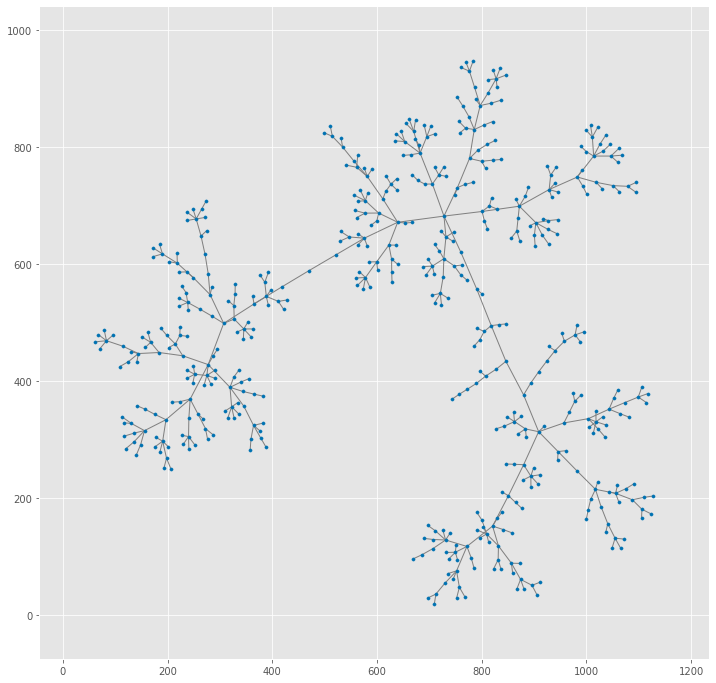

In [76]:
draw(g, pos, s=10, lw=1, labels=False, figsize=[12,12])

In [ ]:
draw(g, pos, s=10, lw=1, labels=True, figsize=[12,12])

## crossing removal

In [ ]:
def isCrossed(e0, e1, pos=None):
    p0,p1 = e0
    q0,q1 = e1
    
    if p0 == q0 or p0 == q1 or p1==q0 or p1==q1: ##if two edges shares a node
        return False
    else:
        p0 = pos[p0]
        p1 = pos[p1]
        q0 = pos[q0]
        q1 = pos[q1]
        e0 = (pos[e0[0]],pos[e0[1]])
        e1 = (pos[e1[0]],pos[e1[1]])
        
        s00 = signOf(q0, e0)
        s10 = signOf(q1, e0)
        s01 = signOf(p0, e1)
        s11 = signOf(p1, e1)
        return s00*s10 <= 0 and s01*s11 <= 0 

    
def signOf(p, e):
    '''sign of point p with repect to the line of edge e'''
    px, py = p
    ax, ay = e[0]
    bx, by = e[1]
    
    a = ay - by
    b = bx - ax
    c = ay * (ax - bx) - ax * (ay - by)
    
    z = px*a + py*b + c
    return np.sign(z)


def subtreeSize(tree, node):
    subtree = nx.bfs_tree(tree, node)
    return len(subtree.nodes), subtree


def shrink(subtree=None, origin=0, by=0.5, pos=None):
    scaleFactor = by
    ox, oy = pos[origin]
    for k in subtree.nodes:
        x,y = pos[k]
        x = ox + scaleFactor * (x-ox)
        y = oy + scaleFactor * (y-oy)
        pos[k] = (x,y)

        
## find a good root
id_pos = pos.items()

ids = np.array([i[0] for i in id_pos])
x = np.array([i[1] for i in id_pos])

centroid = np.mean(x, 0)
dist_to_centroid = np.linalg.norm(x - centroid, 2, 1)
root = ids[np.argmin(dist_to_centroid)]
print('root:', g.nodes[root])

tree = nx.bfs_tree(g, source=root)
scaleFactor = 0.7
hasCrossing = True
while hasCrossing:
    hasCrossing = False
    for e0 in g.edges:
        for e1 in g.edges:
            if isCrossed(e0, e1, pos):
                hasCrossing = True
    #             print(e0, e1)
                sts0, subtree0 = subtreeSize(tree, e0[1])
                sts1, subtree1 = subtreeSize(tree, e1[1])
                if sts0 < sts1:
                    shrink(subtree=subtree0, by=scaleFactor, origin=e0[0], pos=pos)
                else:
                    shrink(subtree=subtree1, by=scaleFactor, origin=e1[0], pos=pos)
                clear_output(wait=True)
                draw(g, pos, labels=False, s=10, lw=1, figsize=[5,5])
                plt.show()

In [ ]:
# xy = np.array( [ pos[i2k[i]]for i in range(len(nodes)) ] )
# theta = (xy[:,0] - xy[:,0].min()) / (xy[:,0].max() - xy[:,0].min()) * np.pi*1
# r = (xy[:,1] - xy[:,1].min())
# # r = -(xy[:,1] - xy[:,1].max())

# xy2 = np.c_[r*np.cos(theta), r*np.sin(theta)]
# pos2 = {i2k[i]:xy2[i] for i in range(len(nodes))}
# draw(g, pos2)

# # pos = pos2

In [ ]:
# from umap import UMAP

# n_neighbors = 15

# umap = UMAP(
#     n_components=2,
#     n_neighbors=n_neighbors, 
#     min_dist=0.3,
#     metric='precomputed',
# #     n_epochs=500,
# #     negative_sample_rate=150,
# #     learning_rate=0.0001,
# #     init=np.array(list(pos.values()))
# )
# xy = umap.fit_transform(d)
# pos2 = {i2k[i]:xy[i,:2] for i in range(len(nodes))}


## New Ordering of Nodes

In [77]:
### list of node ids

#max degree node
degree = list(g.degree)
degree = list(zip(range(len(degree)), degree))
max_degree_node = max(degree, key=lambda x:x[1][1])
start = max_degree_node[1][0]

## random node, bfs
# start = next(iter(g.nodes.keys()))
bfs = nx.bfs_tree(g, start)
node_order = list(bfs) 

##dfs
# node_order = list(nx.dfs_preorder_nodes(g, start))

## no re-ordering
# node_order = list(g.nodes)


## resort according to level
id2level = {i: g.nodes[i]['level'] for i in g.nodes}
nodeorder_level_pairs = [(i,id2level[i]) for i in node_order]
node_order = [n[0] for n in sorted(nodeorder_level_pairs, key=lambda x:x[1])]

## to json

In [78]:
##graph to list
nodes = {k: g.nodes[k] for k in g.nodes}
edges = [[e[0], e[1], g.edges[e]] for e in g.edges]

nodes = [{
    'id': node_order[i],
    'index': i,
    **nodes[node_order[i]]
} for i in range(len(nodes))]

edges = [{
    'source': e[0],
    'target': e[1],
    **e[2]
} for e in edges]

In [79]:
# ##store the position & perplexity
for i,node in enumerate(nodes):
    node['x'] = pos[node_order[i]][0]
    node['y'] = pos[node_order[i]][1]
    node['neighbors'] = list(nx.neighbors(g, node['id']))
#     node['x'] = node['pos'][0]
#     node['y'] = node['pos'][1]
    node['perplexity'] = len(list(nx.neighbors(g, node_order[i])))
    
    try: 
        parent = next(bfs.predecessors(node['id']))
    except StopIteration:
        parent = None
    node['parent'] = parent

    
virtual_edges = []
for i in tqdm(range(len(nodes))):
    for j in range(i+1, len(nodes)):
        if d[i,j] == 0:
            print(f'[warning] d[{i},{j}] = 0')
#         elif hops[i,j] > 12:
#             continue
        else:
            e = {
                'source': i2k[i],
                'target': i2k[j],
                'weight': d[i,j],
                'hops': hops[i,j]
            }
            virtual_edges.append(e)
        
fn_out = fn.replace('dot', 'json').replace('txt', 'json')
print(fn_out)

if not Path(fn_out).parent.exists():
    os.makedirs(Path(fn_out).parent)
with open(fn_out, 'w') as f:
    json.dump(dict(
        edges = edges, 
        virtual_edges = virtual_edges, 
        nodes=nodes
    ), f, indent=2)
print('done')


./data/json/math-genealogy/math-509.json
done


In [ ]:
len(g.nodes)

In [ ]:
for n in nodes:
    n['id'] = n['index']
    del n['x']
    del n['y']